In [2]:
import pandas as pd
import datetime
from geopy import distance
import numpy as np
from collections import defaultdict
import progressbar
import operator
import random
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt


In [3]:
df=pd.read_pickle('processed_data.pickle')
df_300 = df.sample(n=300, random_state=7)
df_300 = df.reset_index().iloc[:,1:]

In [4]:
df_300.head()

,workload,location
0,1507810.0,"(22.522803, 114.218796)"
1,643543.0,"(24.284812, 102.999068)"
2,50378.0,"(25.222206, 117.086322)"
3,3755547.0,"(26.139329, 103.078562)"
4,763464.0,"(26.215115, 109.744661)"


In [5]:
class Species():
    frontier = 0
    distance = 0 
    servers = []
    solution = []
    accessDelay = 0
    workloadBalance = 0
    id = 0 
    def __init__(self,f,d,s,sol,wB,aD, id):
        self.frontier = f
        self.distance = d 
        self.servers = s
        self.solution = sol
        self.accessDelay = aD
        self.workloadBalance = wB
        self.id = id
    def __repr__(self):
        return "Species: " + str(self.id) + " Frontier: " + str(self.frontier) + " distance: " + str(self.distance) + " Access Delay: " + str(self.accessDelay) + " Workload Balance: " + str(self.workloadBalance) + " Servers: " + str(len(self.servers))

In [6]:
def accessDelay(solution, data):
    delay = 0
    i = 0
    for location in solution:
        delay += distance.distance(data.iloc[location]['location'],data.iloc[i]['location']).km
        i+=1
    return delay
def workloadBalance(solution, data):
    servers = dict.fromkeys(solution,0)
    for index,row in data.iterrows():
        servers[solution[index]] +=  row['workload']
    total = 0
    mean = sum(servers.values())/len(servers)
    for key,value in servers.items():
        total += (value - mean)**2
    return np.sqrt(total/len(servers))

In [7]:
def naive_solution(data,servers):
    solution = []
    for j in range(0,len(data)):
        best_server = 0
        min_dist = np.inf
        for server in servers:
            dist = distance.distance(data.iloc[j]['location'],data.iloc[server]['location']).km
            if dist < min_dist:
                best_server = server
                min_dist = dist
        solution.append(best_server)
    return solution

def init_pop(data, server_count = 20, pop_size = 100, server_variance = 5):
    pop = {}
    progress = progressbar.ProgressBar()
    for i in progress(range(pop_size)):
        if server_variance:
            server_n = np.random.randint(server_count-server_variance, server_count + server_variance)
        else:
            server_n = server_count
        servers = list(np.random.choice(range(len(data)),server_n,False)) #list of server_n random servers
        solution = naive_solution(data,servers)
        pop[i] = Species(0,0,servers,solution, workloadBalance(solution,data), accessDelay(solution,data),"Gen 0, Species:" + str(i))
    return pop


In [8]:
data = df[:30]
servers = list(np.random.choice(range(len(data)),5,False))
solution = naive_solution(data,servers)
accessDelay(solution, data)

2844.278341338522

In [9]:
solution

[4,
 1,
 8,
 1,
 4,
 24,
 8,
 24,
 8,
 24,
 24,
 1,
 24,
 24,
 26,
 24,
 26,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 26,
 26,
 24,
 26,
 24]

In [10]:
population = init_pop(data, pop_size = 10)

100% |########################################################################|


In [12]:
def checkDominance(a,b, check_servers = False):
    if check_servers:
        if a.accessDelay < b.accessDelay and a.workloadBalance <= b.workloadBalance and len(a.servers) <= len(b.servers):
            return True
        if a.accessDelay <= b.accessDelay and a.workloadBalance < b.workloadBalance and len(a.servers) <= len(b.servers):
            return True
        if a.accessDelay <= b.accessDelay and a.workloadBalance <= b.workloadBalance and len(a.servers) < len(b.servers):
            return True
    else:
        if a.accessDelay < b.accessDelay and a.workloadBalance <= b.workloadBalance:
            return True
        if a.accessDelay <= b.accessDelay and a.workloadBalance < b.workloadBalance:
            return True
    return False

def nonDominatedSort(population, check_servers = False):
    S = {}
    n = {}
    F = defaultdict(list)
    for key in population.keys():
        S[key] = []
        n[key] = 0
        for key2 in population.keys():
            if key == key2:
                pass
            elif checkDominance(population[key],population[key2], check_servers):
                S[key].append(key2)
            elif checkDominance(population[key2],population[key], check_servers):
                n[key] += 1
        if n[key] == 0:
            population[key].frontier = 0  #set rank of species internally 
            F[0].append(key)
    i = 0
    while F[i] != []:
        Q = []
        for p in F[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    population[q].frontier = i + 1 #set rank of species internally 
                    Q.append(q)
        i = i + 1
        if not Q:
            break
        F[i] = Q
    return F

In [14]:
population

{0: Species: Gen 0, Species:0 Frontier: 1 distance: 0 Access Delay: 1053.4599518020898 Workload Balance: 955728.3811651303 Servers: 22,
 1: Species: Gen 0, Species:1 Frontier: 0 distance: 0 Access Delay: 117.48064554952082 Workload Balance: 1096755.082718012 Servers: 22,
 2: Species: Gen 0, Species:2 Frontier: 1 distance: 0 Access Delay: 697.3476314548166 Workload Balance: 987720.3767635493 Servers: 19,
 3: Species: Gen 0, Species:3 Frontier: 3 distance: 0 Access Delay: 2542.9590747344387 Workload Balance: 1175729.6783982653 Servers: 15,
 4: Species: Gen 0, Species:4 Frontier: 2 distance: 0 Access Delay: 844.1019890865512 Workload Balance: 1175261.0928024037 Servers: 20,
 5: Species: Gen 0, Species:5 Frontier: 0 distance: 0 Access Delay: 299.153397592132 Workload Balance: 852500.833840192 Servers: 24,
 6: Species: Gen 0, Species:6 Frontier: 3 distance: 0 Access Delay: 1411.7084438067848 Workload Balance: 1178792.8783695018 Servers: 18,
 7: Species: Gen 0, Species:7 Frontier: 1 distance

In [13]:
nonDominatedSort(population)

defaultdict(list, {0: [1, 5, 8], 1: [0, 2, 7], 2: [4], 3: [3, 6], 4: [9]})

In [86]:
def crowdingDistance(population, check_servers = False):
    #set distances to 0 
    for member in population:
        member.distance = 0

    population = sorted(population, key = lambda x: x.accessDelay)
    population[0].distance = -np.inf
    population[-1].distance = -np.inf
    for i in range(1,len(population)-1):
        population[i].distance = population[i].distance - (population[i+1].accessDelay - population[i-1].accessDelay)/(population[-1].accessDelay - population[0].accessDelay)
    
    population = sorted(population, key = lambda x: x.workloadBalance)
    population[0].distance = -np.inf
    population[-1].distance = -np.inf
    for i in range(1,len(population)-1):
        population[i].distance = population[i].distance - (population[i+1].workloadBalance - population[i-1].workloadBalance)/(population[-1].workloadBalance - population[0].workloadBalance)
    
    if check_servers:
        population = sorted(population, key = lambda x: len(x.servers))
        population[0].distance = -np.inf
        population[-1].distance = -np.inf
        for i in range(1,len(population)-1):
            population[i].distance = population[i].distance - (len(population[i+1].servers) - len(population[i-1].servers))/(len(population[-1].servers) - len(population[0].servers))


In [87]:
def roulette(choices):
    choice_odds = [] 
    for i in range(len(choices)):
        choice_odds.append((2*(len(choices) - i))/(len(choices)*(len(choices)+1)))

    max = sum([x for x in choice_odds])
    pick = np.random.uniform(0, max)
    current = 0
    selected_choice = 0
    for x in choice_odds:
        current += x
        if current >= pick:
            break
        selected_choice += 1
    return selected_choice

def selection(population, frontiers):
    selected_frontier = roulette(frontiers)
    distances = []
    for i in frontiers[selected_frontier]:
        distances.append((population[i].distance,i))
    distances = sorted(distances)

    selection = roulette(distances)
    try:
        selected_member = distances[selection]
    except Exception:
        print(selection)
        print(distances)
    selected_member = selected_member[1]
    return population[selected_member]


In [89]:

def mutate(data, species, fixed_servers):
    if fixed_servers:
        server = np.random.choice(species.servers)
        new_server = np.random.randint(0,len(species.solution))
        species.servers = list(species.servers)
        species.servers.append(new_server)
        species.servers.remove(server)
        species.solution = naive_solution(data,species.servers)
        species.accessDelay = accessDelay(species.solution,data)
        species.workloadBalance = workloadBalance(species.solution, data) 

def breed(data,a,b,gen,id,fixed_servers):
    if fixed_servers:
        server_count = len(a.servers)
        new_servers = set(a.servers) | set(b.servers)
        try:
            new_servers = np.random.choice(list(new_servers), server_count, False)
        except Exception:
            print(a.servers)
            print(b.servers)
            print(new_servers)
        new_solution = []
        set_new_servers = set(new_servers)
        for i in range(len(a.solution)):
            if a.solution[i] in set_new_servers:
                new_solution.append(a.solution[i])
            elif b.solution[i] in set_new_servers:
                new_solution.append(b.solution[i])
            else:
                best_server = 0
                min_dist = np.inf
                for server in new_servers:
                    dist = distance.distance(data.iloc[i]['location'],data.iloc[server]['location']).km
                    if dist < min_dist:
                        best_server = server
                        min_dist = dist
                new_solution.append(best_server)
        return Species(0,0,new_servers,new_solution, workloadBalance(new_solution,data), accessDelay(new_solution,data), "Gen " + str(gen) + ", Species:" + str(id))

def new_generation(data,population,gen, mutation_rate, fixed_servers):       
    pop_list = sorted(population.values(), key = operator.attrgetter("frontier", "distance"))
    next_gen = {}
    i = 1
    frontiers = nonDominatedSort(population)
    for i in tqdm_notebook(range(len(population)),leave=False, desc='Next Generation'): 
        a = selection(population,frontiers)
        b = selection(population,frontiers)
        new_species = breed(data,a,b,gen,i,fixed_servers)
        n = np.random.random(1)[0]
        if n < mutation_rate:
            mutate(data, new_species, fixed_servers)
        next_gen[new_species.id] = new_species
    return next_gen

In [88]:
def breed(data,a,b,gen,id,fixed_servers):
    '''
    This function generates a new generation of species (population) based on the current population.
    It sorts the population based on the frontier and distance attributes of each species. It iterates through the population and performs selection, crossover, and mutation to create new species for the next generation. The crowding distance is computed for each member of the population.
    Returns the new generation of species.
    '''

In [90]:
access_delay_averages = []
workload_balance_averages = []
access_delay_mins = []
workload_balance_mins = []
def evolution(data,generations = 20, pop_size = 150, server_count = 20, fixed_servers = True):
    population = init_pop(data,pop_size=pop_size, server_count =server_count,server_variance = 0)
    for i in tqdm_notebook(range(generations), desc='Generation'):
        gen = {}
        frontiers = nonDominatedSort(population)
        crowdingDistance(list(population.values()))
        pop_list = sorted(population.values(), key = operator.attrgetter("frontier", "distance"))
        print(pop_list)
        population = {}
        for k in range(0,pop_size):
            id = pop_list[k].id
            population[id] = pop_list[k]

        if i%1 == 0:
            print("Generation: " + str(i))
            ads = []
            wbs = []
            for key,value in population.items():
                ads.append(value.accessDelay)
                wbs.append(value.workloadBalance)
            plt.xlabel("Access Delay")
            plt.ylabel("Workload Balance")
            plt.scatter(ads,wbs)
            plt.show()
            average_ad = sum(ads)/len(ads)
            average_wb = sum(wbs)/len(wbs)
            access_delay_averages.append(average_ad)
            workload_balance_averages.append(average_wb)
            access_delay_mins.append(min(ads))
            workload_balance_mins.append(min(wbs))
            print("Average access delay:" + str(average_ad))
            print("Average workload balance:" + str(average_wb))
            print("Minimum access delay:" + str(min(ads)))
            print("Minimum workload balance:" + str(min(wbs)))

        
        next_gen = new_generation(data,population, i+1, .1, fixed_servers)
        population.update(next_gen)
    gen = {}
    frontiers = nonDominatedSort(population)
    j = 0
    while len(gen) < pop_size:
        front = [population[x] for x in frontiers[j]]
        crowdingDistance(front)
        gen.update({key: value for key, value in population.items() if key in frontiers[j]})
        j += 1
    population = gen
    return frontiers,population
   
        

In [91]:
frontiers,population = evolution(df_300,pop_size=150)

KeyboardInterrupt: 

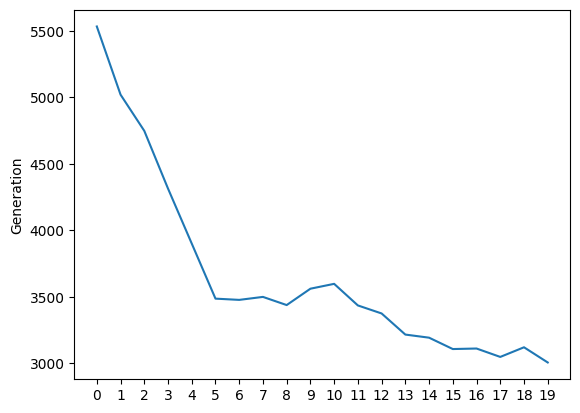

In [ ]:
plt.xlabel("Access delay average")
plt.ylabel("Generation")
plt.xticks(range(0,20))
plt.plot(access_delay_averages)

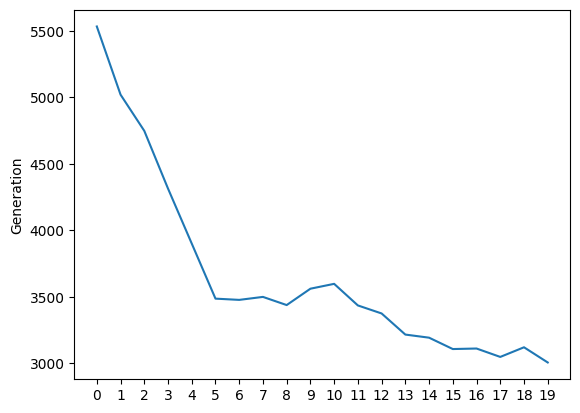

In [ ]:
plt.xlabel("Workload balance average")
plt.ylabel("Generation")
plt.xticks(range(0,20))
plt.plot(workload_balance_averages)

In [ ]:
import pickle

In [ ]:
file = open("results.pickle","wb")
pickle.dump(population, file)

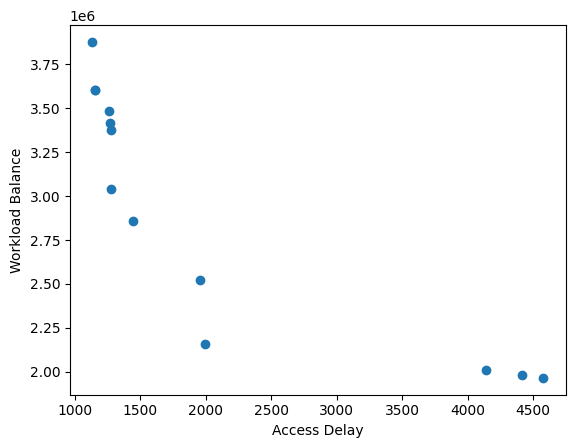

Average Access Delay:2080.8010252740914
Average Workload Balance:2914520.4067937406
Minimum Access Delay:1135.5827081872208
Minimum Workload Balance:1964519.3244820877


In [ ]:
frontiers = nonDominatedSort(population)
front1 = {key:value for key,value in population.items() if value.id in frontiers[0]}
ads = []
wbs = []
for key,value in front1.items():
    ads.append(value.accessDelay)
    wbs.append(value.workloadBalance)
plt.xlabel("Access Delay")
plt.ylabel("Workload Balance")
plt.scatter(ads,wbs)
plt.show()
average_ad = sum(ads)/len(ads)
average_wb = sum(wbs)/len(wbs)
access_delay_averages.append(average_ad)
workload_balance_averages.append(average_wb)
access_delay_mins.append(min(ads))
workload_balance_mins.append(min(wbs))
print("Average access delay:" + str(average_ad))
print("Average workload balance:" + str(average_wb))
print("Minimum access delay:" + str(min(ads)))
print("Minimum workload balance:" + str(min(wbs)))